In [1]:
import numpy as np
import random
import torch.nn as nn
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from collections import deque
from skimage.color import rgb2gray
import pickle

<h3> Load the game environment </h3>

In [2]:
from gridworld import gameEnv

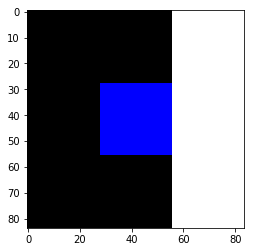

In [10]:
env = gameEnv(partial=True,size=9)
prev_state = env.reset()

<h3> Set Device </h3>

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<h1 align='center'> Training Deep Recurrent Q Network (LSTM) </h1>

<h3> Hyper-parameters </h3>

In [5]:
INPUT_IMAGE_DIM = 84
OUT_SIZE = 4
BATCH_SIZE = 32
TIME_STEP = 8
GAMMA = 0.99
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
TOTAL_EPSIODES = 20000
MAX_STEPS = 50
MEMORY_SIZE = 3000
UPDATE_FREQ = 5
PERFORMANCE_SAVE_INTERVAL = 500
TARGET_UPDATE_FREQ = 20000 #steps

<h3> Build Model </h3>

In [6]:
class Network(nn.Module):
    
    def __init__(self,input_size,out_size):
        super(Network,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        self.conv_layer1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=8,stride=4) # potential check - in_channels
        self.conv_layer2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2)
        self.conv_layer3 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1)
        self.conv_layer4 = nn.Conv2d(in_channels=64,out_channels=512,kernel_size=7,stride=1)
        self.lstm_layer = nn.LSTM(input_size=512,hidden_size=512,num_layers=1,batch_first=True)
        self.adv = nn.Linear(in_features=512,out_features=self.out_size)
        self.val = nn.Linear(in_features=512,out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x,bsize,time_step,hidden_state,cell_state):
        x = x.view(bsize*time_step,1,self.input_size,self.input_size)
        
        conv_out = self.conv_layer1(x)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer2(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer3(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer4(conv_out)
        conv_out = self.relu(conv_out)
        
        conv_out = conv_out.view(bsize,time_step,512)
        
        lstm_out = self.lstm_layer(conv_out,(hidden_state,cell_state))
        out = lstm_out[0][:,time_step-1,:]
        h_n = lstm_out[1][0]
        c_n = lstm_out[1][1]
        
        adv_out = self.adv(out)
        val_out = self.val(out)
        
        qout = val_out.expand(bsize,self.out_size) + (adv_out - adv_out.mean(dim=1).unsqueeze(dim=1).expand(bsize,self.out_size))
        
        return qout, (h_n,c_n)
    
    def init_hidden_states(self,bsize):
        h = torch.zeros(1,bsize,512).float().to(device)
        c = torch.zeros(1,bsize,512).float().to(device)
        
        return h,c
    
main_model = Network(input_size=INPUT_IMAGE_DIM,out_size=OUT_SIZE).to(device)
print(main_model)

Network(
  (conv_layer1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv_layer2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv_layer3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer4): Conv2d(64, 512, kernel_size=(7, 7), stride=(1, 1))
  (lstm_layer): LSTM(512, 512, batch_first=True)
  (adv): Linear(in_features=512, out_features=4, bias=True)
  (val): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)


<h3>Experience Replay </h3>

In [7]:
class Memory():
    
    def __init__(self,memsize):
        self.memsize = memsize
        self.memory = deque(maxlen=self.memsize)
    
    def add_episode(self,epsiode):
        self.memory.append(epsiode)
    
    def get_batch(self,bsize,time_step):
        sampled_epsiodes = random.sample(self.memory,bsize)
        batch = []
        for episode in sampled_epsiodes:
            point = np.random.randint(0,len(episode)+1-time_step)
            batch.append(episode[point:point+time_step])
        return batch

<h3> Preprocess Image </h3>

In [8]:
def preprocess_image(image):
    return rgb2gray(image)

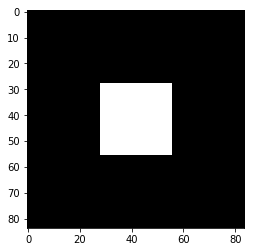

In [11]:
plt.imshow(preprocess_image(prev_state),cmap='gray')

<h3> Save Dictionary Function </h3>

In [12]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

<h3> DQN With LSTM </h3>

In [ ]:
mem = Memory(memsize=MEMORY_SIZE)

main_model = Network(input_size=INPUT_IMAGE_DIM,out_size=OUT_SIZE).float().to(device)
target_model = Network(input_size=INPUT_IMAGE_DIM,out_size=OUT_SIZE).float().to(device)

target_model.load_state_dict(main_model.state_dict())
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(main_model.parameters(),lr=0.00025)


# Fill memory
for i in range(0,MEMORY_SIZE):
    
    prev_state = env.reset()
    processed_prev_state = preprocess_image(prev_state)
    step_count = 0
    local_memory = []
    
    while step_count < MAX_STEPS:
        
        step_count +=1
        action = np.random.randint(0,4)
        next_state,reward,done = env.step(action)
        processed_next_state = preprocess_image(next_state)
        
        local_memory.append((processed_prev_state,action,reward,processed_next_state))
        
        prev_state = next_state
        processed_prev_state = processed_next_state
    
    mem.add_episode(local_memory)
        
print('Populated with %d Episodes'%(len(mem.memory)))

# Start Algorithm
epsilon = INITIAL_EPSILON
loss_stat = []
reward_stat = []
total_steps = 0

for episode in range(0,TOTAL_EPSIODES):
    
    prev_state = env.reset()
    processed_prev_state = preprocess_image(prev_state)
    total_reward = 0
    step_count = 0
    local_memory = []

    hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
    
    while step_count < MAX_STEPS:
        
        step_count +=1
        total_steps +=1
        
        if np.random.rand(1) < epsilon:
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            action = np.random.randint(0,4)
            hidden_state = model_out[1][0]
            cell_state = model_out[1][1]
            
        else:
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            out = model_out[0]
            action = int(torch.argmax(out[0]))
            hidden_state = model_out[1][0]
            cell_state = model_out[1][1]
        
        next_state,reward,done = env.step(action)
        total_reward += reward
        processed_next_state = preprocess_image(next_state)
        
        local_memory.append((processed_prev_state,action,reward,processed_next_state))
        
        prev_state = next_state
        processed_prev_state = processed_next_state
        
        
        if (total_steps % TARGET_UPDATE_FREQ) == 0:
            target_model.load_state_dict(main_model.state_dict())
       
        if (total_steps % UPDATE_FREQ) == 0:
            
            hidden_batch, cell_batch = main_model.init_hidden_states(bsize=BATCH_SIZE)
            
            batch = mem.get_batch(bsize=BATCH_SIZE,time_step=TIME_STEP)
            
            current_states = []
            acts = []
            rewards = []
            next_states = []
            
            for b in batch:
                cs,ac,rw,ns = [],[],[],[]
                for element in b:
                    cs.append(element[0])
                    ac.append(element[1])
                    rw.append(element[2])
                    ns.append(element[3])
                current_states.append(cs)
                acts.append(ac)
                rewards.append(rw)
                next_states.append(ns)
            
            current_states = np.array(current_states)
            acts = np.array(acts)
            rewards = np.array(rewards)
            next_states = np.array(next_states)
            
            torch_current_states = torch.from_numpy(current_states).float().to(device)
            torch_acts = torch.from_numpy(acts).long().to(device)
            torch_rewards = torch.from_numpy(rewards).float().to(device)
            torch_next_states = torch.from_numpy(next_states).float().to(device)
            
            
            Q_next,_ = target_model.forward(torch_next_states,bsize=BATCH_SIZE,time_step=TIME_STEP,hidden_state=hidden_batch,cell_state=cell_batch)
            Q_next_max,__ = Q_next.detach().max(dim=1)
            target_values = torch_rewards[:,TIME_STEP-1] + (GAMMA * Q_next_max)
            
            Q_s, _ = main_model.forward(torch_current_states,bsize=BATCH_SIZE,time_step=TIME_STEP,hidden_state=hidden_batch,cell_state=cell_batch)
            Q_s_a = Q_s.gather(dim=1,index=torch_acts[:,TIME_STEP-1].unsqueeze(dim=1)).squeeze(dim=1)
            
            
            loss = criterion(Q_s_a,target_values)
            
            #  save performance measure
            loss_stat.append(loss.item())
            
            # make previous grad zero
            optimizer.zero_grad()
            
            # backward
            loss.backward()
            
            # update params
            optimizer.step()

    # save performance measure
    reward_stat.append(total_reward)
    
    mem.add_episode(local_memory)

    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/TOTAL_EPSIODES
    
    if (episode + 1)% PERFORMANCE_SAVE_INTERVAL == 0:
        perf = {}
        perf['loss'] = loss_stat
        perf['total_reward'] = reward_stat
        save_obj(name='LSTM_POMDP_V4',obj=perf)
    
    #print('Episode : ',episode+1,'Epsilon : ',epsilon,'Reward : ',total_reward,)
            

Populated with 3000 Episodes


<h3> Save Primary Network Weights </h3>

In [ ]:
torch.save(main_model.state_dict(),'data/LSTM_POMDP_V4_WEIGHTS.torch')

<h1 align='center'> Testing Policy </h1>

<h3> Load Primary Network Weights </h3>

In [13]:
weights = torch.load('data/LSTM_POMDP_V4_WEIGHTS.torch')
main_model.load_state_dict(weights)

In [ ]:
# Start Testing
epsilon = INITIAL_EPSILON
FINAL_EPSILON = 0.01
TOTAL_EPSIODES = 10000
loss_stat = []
reward_stat = []
total_steps = 0

for episode in range(0,TOTAL_EPSIODES):
    
    prev_state = env.reset()
    processed_prev_state = preprocess_image(prev_state)
    total_reward = 0
    step_count = 0
    
    hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
    
    while step_count < MAX_STEPS:
        
        step_count +=1
        total_steps +=1
        
        if np.random.rand(1) < epsilon:
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            action = np.random.randint(0,4)
            hidden_state = model_out[1][0]
            cell_state = model_out[1][1]
            
        else:
            torch_x = torch.from_numpy(processed_prev_state).float().to(device)
            model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
            out = model_out[0]
            action = int(torch.argmax(out[0]))
            hidden_state = model_out[1][0]
            cell_state = model_out[1][1]
        
        next_state,reward,done = env.step(action)
        total_reward += reward
        processed_next_state = preprocess_image(next_state)
        
        prev_state = next_state
        processed_prev_state = processed_next_state
            
    # save performance measure
    reward_stat.append(total_reward)
    
    if epsilon > FINAL_EPSILON:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/TOTAL_EPSIODES
    
    if (episode + 1)% PERFORMANCE_SAVE_INTERVAL == 0:
        perf = {}
        perf['loss'] = loss_stat
        perf['total_reward'] = reward_stat
        save_obj(name='LSTM_POMDP_V4_TEST',obj=perf)
    
    print('Episode : ',episode+1,'Epsilon : ',epsilon,'Reward : ',total_reward)
            

<h1 align='center'> Create Policy GIF </h1>

<h3> Collect Frames Of an Episode Using Trained Network </h3>

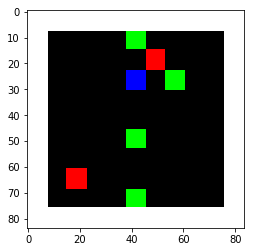

In [12]:
full_env = gameEnv(partial=False,size=9)

In [13]:
frames = []
local_frames = []
random.seed(110)
np.random.seed(110)

for episode in range(0,1):
    
    prev_state = env.reset()
    random.seed(110)
    np.random.seed(110)
    full_env_prev = full_env.reset()
    
    frames.append(full_env_prev)
    local_frames.append(prev_state)
    processed_prev_state = preprocess_image(prev_state)
    total_reward = 0
    step_count = 0
    
    hidden_state, cell_state = main_model.init_hidden_states(bsize=1)
    
    while step_count < MAX_STEPS:
        
        step_count +=1
        
        torch_x = torch.from_numpy(processed_prev_state).float().to(device)
        model_out = main_model.forward(torch_x,bsize=1,time_step=1,hidden_state=hidden_state,cell_state=cell_state)
        out = model_out[0]
        action = int(torch.argmax(out[0]))
        hidden_state = model_out[1][0]
        cell_state = model_out[1][1]
        
        next_state, reward, d = env.step(action)
        full_env_next,r,g = full_env.step(action)
        total_reward += reward
        frames.append(full_env_next)
        local_frames.append(next_state)
        processed_next_state = preprocess_image(next_state)
        
        
        prev_state = next_state
        processed_prev_state = processed_next_state

print('Total Reward : %d'%(total_reward))

Total Reward : 3


<h3> Frames to GIF </h3>

In [16]:
import imageio
from scipy.misc import imresize
resized_frames = []
resized_local_frames = []

for i in range(0,len(frames)):
    resized_frames.append(imresize(frames[i],(256,256)))
    resized_local_frames.append(imresize(local_frames[i],(256,256)))

imageio.mimsave('data/GIFs/LSTM_SIZE_9_frames.gif',resized_frames,fps=3)
imageio.mimsave('data/GIFs/LSTM_SIZE_9_local.gif',resized_local_frames,fps=3)

/home/mayank/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/mayank/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
